In [1]:
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS); path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [3]:
path_img = path/'images'

In [4]:
src = (ImageImageList.from_folder(path_img)
       .use_partial_data(0.3, seed=42)
       .split_by_rand_pct(0.1, seed=42))

In [5]:
bs,sz = 128,64
dbch = (src.label_from_func(lambda x: x)
        .transform(get_transforms(), tfm_y=True, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

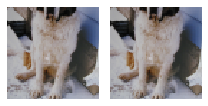

In [6]:
dbch.show_batch(rows=1, figsize=(3,3))

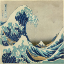

In [7]:
style_img = open_image('styles/wave.jpg').resize(sz)
style_timg = normalize(style_img.px, *map(tensor, imagenet_stats)).cuda()[None]; style_img

In [8]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [9]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw):
        super().__init__()
        self.m_feat,self.cnt_ls,self.stl_ls,self.cnt_lsw,self.stl_lsw=m_feat,cnt_ls,stl_ls,cnt_lsw,stl_lsw
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self._stl_loss(pred_stl_fs)
#         cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        return stl_loss #+ cnt_loss # Add a weight for each loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w**2*5e3
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w**2*5e3 for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [10]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [11]:
convs = [l for l in vgg_m.children() if isinstance(l,nn.Conv2d)]; len(convs)

13

In [12]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [13]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[2:5], stl_ls= convs,
                          cnt_lsw=[5,15,2]   , stl_lsw=np.ones(len(convs)))
fst_loss.register_style(style_timg)

In [14]:
learn = unet_learner(dbch, models.resnet34, wd=1e-3, loss_func=fst_loss,
                     blur=True, norm_type=NormType.Spectral,
                     self_attention=True, y_range=(-3, 3)).to_fp16()

In [15]:
# learn.lr_find(); learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, 3e-2, pct_start=.72)

epoch,train_loss,valid_loss,time
0,67.377922,39.223717,00:25
1,47.446922,23.858479,00:13
2,36.202309,17.396465,00:13
3,29.287224,16.108509,00:13
4,25.045404,15.735180,00:13


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([128, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (t

In [17]:
# learn.unfreeze()
# learn.lr_find(); learn.recorder.plot()

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, 5e-3))

epoch,train_loss,valid_loss,time
0,16.426138,15.642472,00:13
1,16.302450,15.347842,00:17
2,16.128962,14.968869,00:25
3,15.887128,14.546185,00:21
4,15.171828,12.669071,00:21
5,14.290448,11.532038,00:22
6,13.468531,11.058841,00:22
7,12.761561,11.008635,00:22
8,12.212931,10.666632,00:22
9,11.807239,10.626606,00:22


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([128, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (t

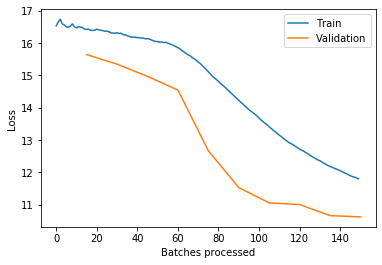

In [19]:
learn.recorder.plot_losses()

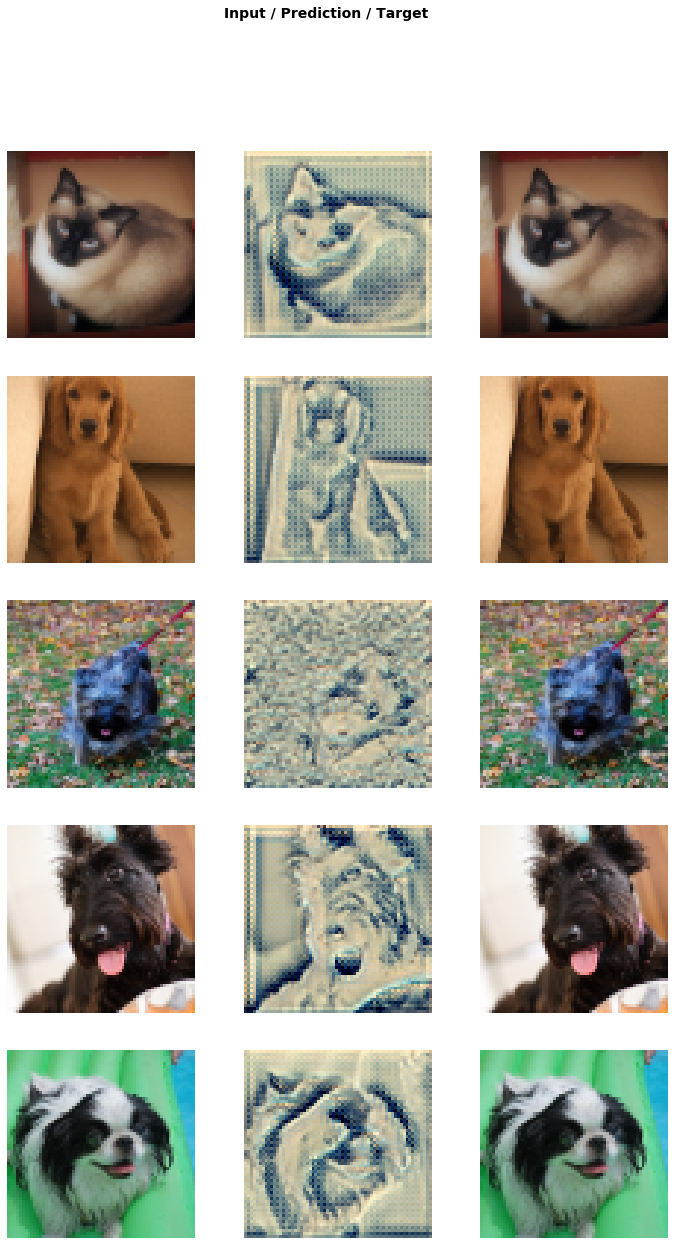

In [20]:
learn.show_results()